<a href="https://colab.research.google.com/github/Reza-Pourang/Finance-Customer-Segmentation/blob/main/ML_Project_Prediction%26Business_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries

import numpy as np
import pandas as pd

#Loading dataset
from google.colab import drive
drive.mount('/content/drive')
Data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CleanedBank.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler


#Preprocessing: Encode Categorical Variables
#One-Hot Encoding for nominal variables
DataEncoded = pd.get_dummies(Data, columns = ['job', 'marital', 'poutcome'], drop_first=True)

#Label Encoding for ordinal and binary variables
LE = LabelEncoder()
ColumnstoLE = ["education", "default", "housing", "loan", "y"]
for col in ColumnstoLE:
  DataEncoded[col] = LE.fit_transform(DataEncoded[col])


#Preprocessing: Scale Numerical Features
#Create a binary indicator for 'pdays'
DataEncoded['Contacted_before'] = DataEncoded['pdays'].apply(lambda x: 1 if x > -1 else 0)

#Keep -1 in 'pdays' and scale it by MinMaxScaler
MinMax = MinMaxScaler()
DataEncoded['pdays'] = MinMax.fit_transform(DataEncoded[['pdays']])

#Scale numerical features
NumericalColumns = ['age', 'balance', 'campaign', 'pdays', 'previous']
Scaler = StandardScaler()
DataEncoded[NumericalColumns] = Scaler.fit_transform(DataEncoded[NumericalColumns])


#Preprocessing: Feature Engineering
#How financial stability varies by age?
DataEncoded['AgeBalance'] = DataEncoded['age'] * DataEncoded['balance']
DataEncoded['AgeBalance'] = MinMaxScaler().fit_transform(DataEncoded[['AgeBalance']])

#Identify customers with zero balance or campaign
DataEncoded['ZeroBalance'] = (DataEncoded['balance'] == 0).astype(int)
DataEncoded['ZeroCampaign'] = (DataEncoded['campaign'] == 0).astype(int)

In [ ]:
#Apply Gaussian Mixture Models
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

ClusteringFeatures = ['age', 'education', 'balance', 'campaign', 'pdays', 'previous',
                      'Contacted_before', 'AgeBalance']

#GMM with 3 clusters (the optimal number after trying different numbers from 1 to 10)
GMMModel = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
DataEncoded['Cluster_GMM'] = GMMModel.fit_predict(DataEncoded[ClusteringFeatures])

#Evaluation Metrics
Silhouette_GMM = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM'])
DBI_GMM = davies_bouldin_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM'])
CH_GMM = calinski_harabasz_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM'])

#Print Evaluation Metrics
print(f"Silhouette Score (GMM): {Silhouette_GMM:.4f}")
print(f"Davies-Bouldin Index (GMM): {DBI_GMM:.4f}")
print(f"Calinski-Harabasz Score (GMM): {CH_GMM:.4f}")

Silhouette Score (GMM): 0.4179
Davies-Bouldin Index (GMM): 1.1656
Calinski-Harabasz Score (GMM): 8814.5631


In [ ]:
#Analyze and Profile Clusters

#Key statistics for each cluster
ClusterSummary = DataEncoded.groupby('Cluster_GMM')[ClusteringFeatures].mean()
print('Cluster Characteristics:\n', ClusterSummary)

#Count of clusters for each cluster
ClusterCounts = DataEncoded['Cluster_GMM'].value_counts()
print('\nCluster Counts:\n', ClusterCounts)

Cluster Characteristics:
                   age  education   balance  campaign     pdays  previous  \
Cluster_GMM                                                                
0            0.614252   1.273944  4.203385 -0.026618 -0.405225 -0.247198   
1           -0.000377   1.207006  0.054341 -0.228673  1.838837  1.118306   
2           -0.017295   1.132861 -0.131469  0.053453 -0.412311 -0.250730   

             Contacted_before  AgeBalance  
Cluster_GMM                                
0                    0.004119    0.147643  
1                    1.000000    0.129654  
2                    0.000000    0.129198  

Cluster Counts:
 Cluster_GMM
2    34314
1     7908
0      971
Name: count, dtype: int64


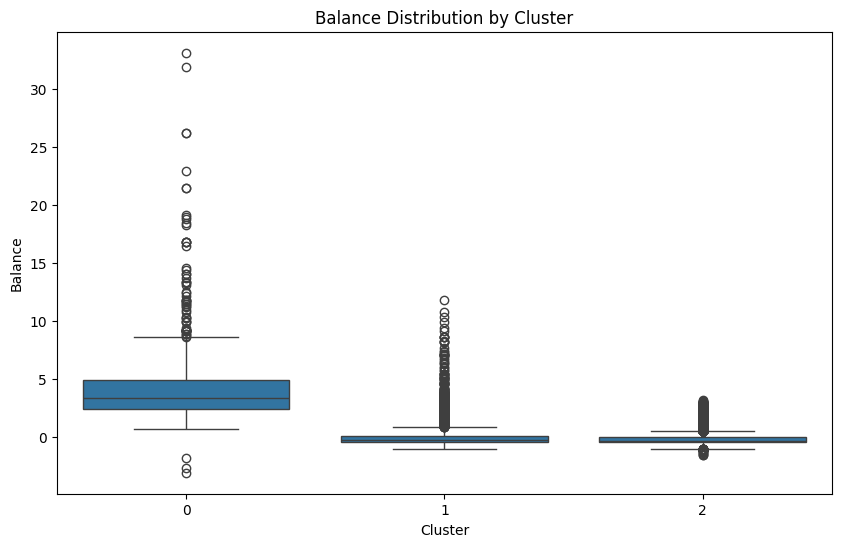

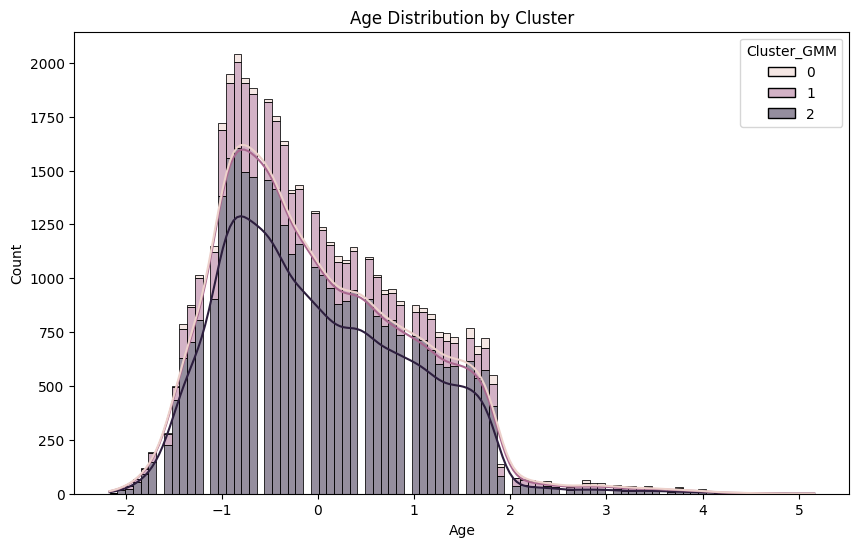

Text(0.5, 0, 'Age')

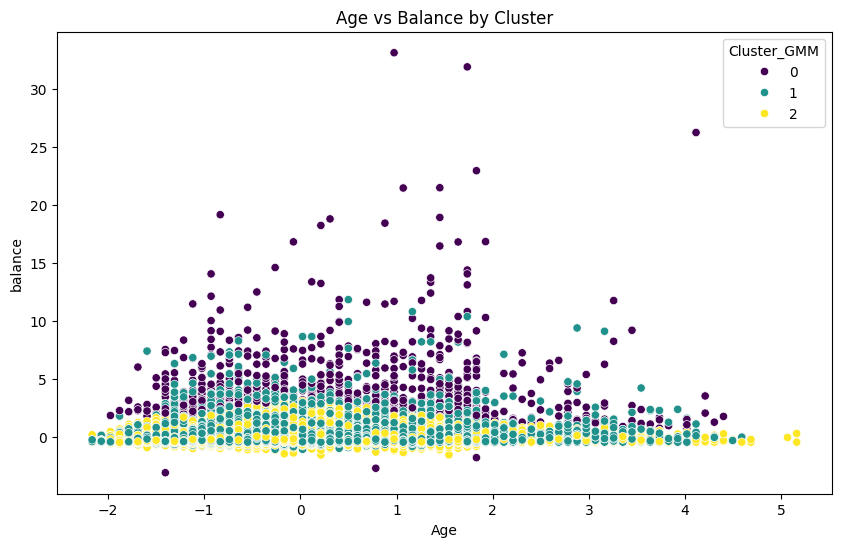

In [ ]:
#Visualize Cluster Results

import seaborn as sns
import matplotlib.pyplot as plt

#Boxplot for Balance by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_GMM', y='balance', data=DataEncoded)
plt.title('Balance Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Balance')
plt.show()
print('\n')

#Age Distribution by Cluster
plt.figure(figsize=(10, 6))
sns.histplot(data=DataEncoded, x='age', hue='Cluster_GMM', kde=True, multiple='stack')
plt.title('Age Distribution by Cluster')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
print('\n')

#Scatter Plot for Age vs Balance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='balance', hue='Cluster_GMM', data=DataEncoded, palette='viridis')
plt.title('Age vs Balance by Cluster')
plt.xlabel('Age')

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       209
           1       1.00      1.00      1.00      1545
           2       1.00      1.00      1.00      6885

    accuracy                           1.00      8639
   macro avg       1.00      1.00      1.00      8639
weighted avg       1.00      1.00      1.00      8639



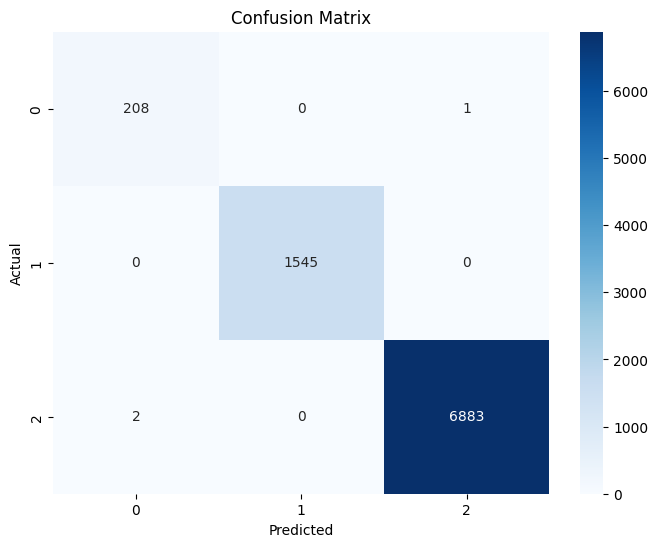

In [ ]:
#Predictive Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#Prepare Data for Prediction (Features & Target)
X = DataEncoded[ClusteringFeatures]
y = DataEncoded['Cluster_GMM']

#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a Random Forest Classifier
RFModel = RandomForestClassifier(random_state=42)
RFModel.fit(X_train, y_train)
y_pred = RFModel.predict(X_test)

#Model Evaluation
print('Classification Report:\n', classification_report(y_test, y_pred))


#Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Generate Business Insights

#Identify High-Balance Customers
HighBalanceCustomers = ClusterSummary['balance'].idxmax()
HighBalanceCustomers = DataEncoded[DataEncoded["Cluster_GMM"] == HighBalanceCustomers]
print("High-Balance Customer Profile:\n", HighBalanceCustomers.describe())

High-Balance Customer Profile:
               age   education     default     balance     housing        loan  \
count  971.000000  971.000000  971.000000  971.000000  971.000000  971.000000   
mean     0.614252    1.273944    0.004119    4.203385    0.403708    0.059732   
std      1.325537    0.731564    0.064084    3.296705    0.490893    0.237112   
min     -1.975177    0.000000    0.000000   -3.081136    0.000000    0.000000   
25%     -0.643431    1.000000    0.000000    2.376663    0.000000    0.000000   
50%      0.783439    1.000000    0.000000    3.333249    0.000000    0.000000   
75%      1.544437    2.000000    0.000000    4.881867    1.000000    0.000000   
max      4.398177    2.000000    1.000000   33.126465    1.000000    1.000000   

         campaign       pdays    previous           y  Contacted_before  \
count  971.000000  971.000000  971.000000  971.000000        971.000000   
mean    -0.026618   -0.405225   -0.247198    0.147271          0.004119   
std      0.93

In [ ]:
#Generate Business Insights

#Identify Customers Frequently Contacted in Campaigns
HighCampaignCluster = ClusterSummary['campaign'].idxmax()
FrequentCampaignCustomers = DataEncoded[DataEncoded["Cluster_GMM"] == HighCampaignCluster]
print("\nFrequent Campaign Contacts:\n", FrequentCampaignCustomers.describe())


Frequent Campaign Contacts:
                 age     education       default       balance       housing  \
count  34314.000000  34314.000000  34314.000000  34314.000000  34314.000000   
mean      -0.017295      1.132861      0.021041     -0.131469      0.551262   
std        0.966769      0.665465      0.143523      0.498206      0.497373   
min       -2.165426      0.000000      0.000000     -1.553557      0.000000   
25%       -0.833681      1.000000      0.000000     -0.429322      0.000000   
50%       -0.167808      1.000000      0.000000     -0.319528      1.000000   
75%        0.688314      2.000000      0.000000     -0.043072      1.000000   
max        5.159175      2.000000      1.000000      3.165600      1.000000   

               loan      campaign         pdays      previous             y  \
count  34314.000000  34314.000000  3.431400e+04  3.431400e+04  34314.000000   
mean       0.173282      0.053453 -4.123112e-01 -2.507296e-01      0.089847   
std        0.378496  